In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from PIL import Image
import numpy as np
import glob

import cv2
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from IPython.display import clear_output

print('Is CUDA available ?', torch.cuda.is_available())
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

Is CUDA available ? True


In [2]:
class LoadData(Dataset):
    def __init__(self, dirpath, transform=None):
        """ Initialize dataset """
        self.filepaths = []
        self.transform = transform
        
        #for i in range(20888, 30001):
            #self.filepaths.append(dirpath + f"\\seed{i}.png")
            
        for fp in glob.glob(dirpath + "/*.png"):
            self.filepaths.append(fp)
            
    def __getitem__(self, index):
        """ Get a sample from the dataset """
        fp = self.filepaths[index]
        try:
            image = Image.open(fp)
            image.verify()  # Verify the contents of the file
            image.close()
            image = Image.open(fp)  # Reopen for further operations
            if self.transform is not None:
                image = self.transform(image)
                
            image.unsqueeze(0)
            return image
        
        except (IOError, OSError) as e:
            print(f"Error opening the image file: {e}")
    
    def __len__(self):
        """ Get total number of samples in the dataset """
        return len(self.filepaths)        

In [3]:
TrainingData = LoadData(
    dirpath='C:\\Users\\User\\Downloads\\AnimeGAN\\out2',
    transform=T.Compose([
        T.Resize((128, 128)),
        T.ToTensor()
    ])
)

In [4]:
def imageshow(sample):
    """ show the image of a sample """
    image = sample
    
    plt.imshow(np.transpose(image, (1, 2, 0)))
    plt.show()

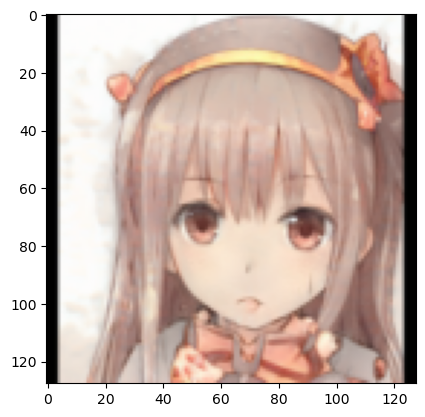

torch.Size([3, 128, 128])


In [5]:
train = iter(TrainingData)
sample = next(train)
imageshow(sample)
print(sample.shape)

In [6]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [7]:
class Generator(nn.Module):
    """
    input (N, in_dim)
    output (N, 3, 128, 128)
    
    """
    def __init__(self, in_dim):
        super(Generator, self).__init__()
        def dconv_bn_relu(in_dim, out_dim):
            return nn.Sequential(
                nn.ConvTranspose2d(in_dim, out_dim, 5, 2,
                                   padding=2, output_padding=1, bias=False),
                nn.BatchNorm2d(out_dim),
                nn.ReLU())
        
        #kernel = 5, stride = 2, padding = 2, output_padding = 1
        #(64-1) * stride - 2 * padding + 1 * (kernel - 1) + output_padding + 1
        #63 * 2 - 2 * 2 + 4 + 1 + 1 = 128
        #127 * 2 - 2 * 2 + 4 + 1 + 1 = 256
        
        self.l1 = nn.Sequential(
                                    nn.Linear(in_dim, 64 * 8 * 4 * 4, bias=False),
                                    nn.BatchNorm1d(64 * 8 * 4 * 4),
                                    nn.ReLU()
                                )
        
        self.l2_5 = nn.Sequential(
                                    # 512 x 4 x 4
                                    dconv_bn_relu(512, 256),
                                    # 256 x 8 x 8
                                    dconv_bn_relu(256, 128),
                                    # 128 x 16 x 16
                                    dconv_bn_relu(128, 64),
                                    # 64 x 32 x 32
                                    dconv_bn_relu(64, 32),
                                    # 32 x 64 x 64
                                    nn.ConvTranspose2d(32, 3, 5, 2, padding=2, output_padding=1),
                                    # 3 x 128 x 128
                                    nn.Tanh()
                                )
        
        self.apply(weights_init)
        
    def forward(self, x):
        
        # x.shape = batchsize x 100
        y = self.l1(x)
        # batchsize x 512 x 4 x 4
        y = y.view(y.size(0), -1, 4, 4)
        y = self.l2_5(y)
        return y

class Discriminator(nn.Module):
    """
    input (N, 3, 128, 128)
    output (N, )
    """
    def __init__(self, in_dim):
        super(Discriminator, self).__init__()
        def conv_bn_lrelu(in_dim, out_dim):
            return nn.Sequential(
                nn.Conv2d(in_channels = in_dim, out_channels = out_dim, kernel_size = 5, stride = 2, padding = 2),
                nn.BatchNorm2d(out_dim),
                nn.LeakyReLU(0.2))
        
        self.cnn = nn.Sequential(
            # 3 x 128 x 128
            conv_bn_lrelu(3, 16),
            # 16 x 64 x 64
            conv_bn_lrelu(16, 32),
            # 32 x 32 x 32
            conv_bn_lrelu(32, 64),
            # 64 x 16 x 16
            conv_bn_lrelu(64, 128),
            # 128 x 8 x 8
            conv_bn_lrelu(128, 256),
            # 256 x 4 x 4
            conv_bn_lrelu(256, 512),
            # 512 x 2 x 2
            nn.Flatten()
        )
        
        self.linear1 = nn.Linear(in_features = 512 * 2 * 2, out_features = 32)
        self.linear2 = nn.Linear(32, 1)
        
        self.apply(weights_init)   
        
    def forward(self, x):
        x = self.cnn(x)
        x = nn.functional.relu(self.linear1(x))
        x = nn.functional.sigmoid(self.linear2(x))
        
        return x

In [8]:
batch_size = 256
nz = 100  # Size of z latent vector (i.e., size of generator input)
num_epochs = 200  # Number of training epochs
lr = 0.0002
beta1 = 0.5
dataloader = DataLoader(TrainingData, batch_size=batch_size, shuffle=True)

In [9]:
generator = Generator(nz).to(device)
discriminator = Discriminator(in_dim = 3).to(device) 
optimizerD = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
criterion = nn.BCELoss()

In [10]:
#generator.train()
#discriminator.train()
discriminatorloss = []
generatorloss = []

for epoch in range(num_epochs):
    generator.train()
    discriminator.train()

    discriminatorl = 0
    generatorl = 0
    count = 0
    for i, (train_images) in enumerate(dataloader):
        count += 1
        # Move images to device
        train_images = train_images.to(device)
        
        # Train Discriminator
        label_real = torch.ones(train_images.size(0), 1, device=device)
        label_fake = torch.zeros(train_images.size(0), 1, device=device)
        
        # Real images
        output_real = discriminator(train_images)
        errD_real = criterion(output_real, label_real)
        
        # Fake images
        noise = torch.randn(train_images.size(0), nz, device=device)
        fake_images = generator(noise)
        output_fake = discriminator(fake_images.detach())  # Detach for only updating discriminator
        errD_fake = criterion(output_fake, label_fake)

        # Backpropagation + Optimize for discriminator
        discriminator.zero_grad()
        errD = errD_real + errD_fake
        discriminatorl += errD.cpu().detach().numpy()
        errD.backward()
        optimizerD.step()

        # Train Generator
        # Update generator which tries to fool discriminator
        output_fake = discriminator(fake_images)  # No detach() here because we train generator
        errG = criterion(output_fake, label_real)
        generatorl += errG.cpu().detach().numpy()
        generator.zero_grad()
        errG.backward()
        optimizerG.step()
        
        clear_output(wait = True)
        print(f"[{epoch} / {num_epochs}] Loss_D: {round(discriminatorl / count, 4)}, Loss_G: {round(generatorl / count, 4)}")  
        
    discriminato  r.m   mloss.append(discriminatorl / count)
    generatorloss.append(generatorl / count)
    if (epoch) % 5 == 0: 
        generator.eval()
        noise = torch.randn(10, nz, device=device)
        fake_images = generator(noise)
        grid_img = torchvision.utils.make_grid(fake_images.cpu(), nrow=5)
        plt.figure(figsize=(10,10))
        plt.imshow(grid_img.permute(1, 2, 0))
        plt.savefig(f"./result/Epoch{epoch}.jpg", dpi = 300, bbox_inches = 'tight')
        plt.show()
        
        torch.save(generator.state_dict(), f'./result/gan_g_epoch{epoch}.pth')
        torch.save(discriminator.state_dict(), f'./result/gan_d_epoch{epoch}.pth')
        

[199 / 200] Loss_D: 0.1918, Loss_G: 5.3245


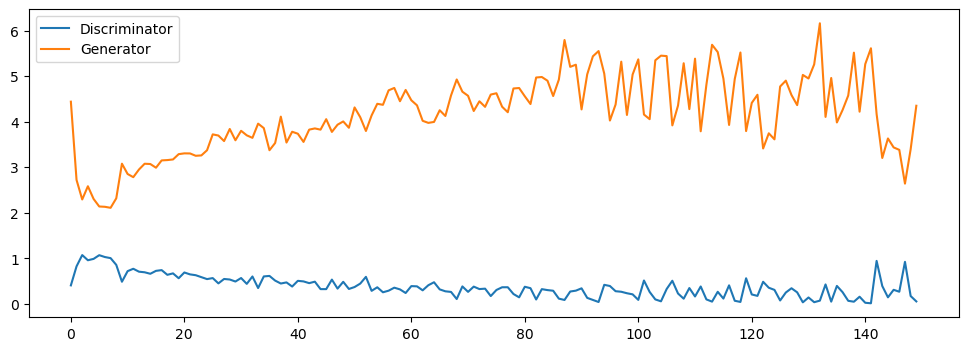

In [54]:
plt.figure(figsize = (12, 4))

plt.plot(discriminatorloss[: 150], label = 'Discriminator')
plt.plot(generatorloss[: 150], label = 'Generator')
plt.legend()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


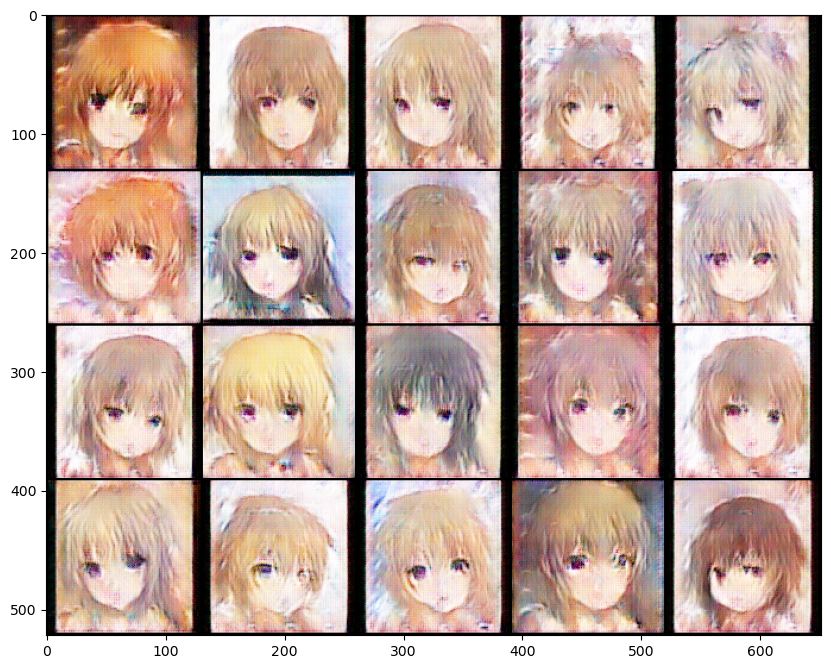

In [62]:
generator = Generator(nz).to(device)
generator.load_state_dict(torch.load(F'./result/gan_g_epoch{125}.pth'))
generator.eval()

noise = torch.randn(20, nz, device=device)
fake_images = generator(noise)
grid_img = torchvision.utils.make_grid(fake_images.cpu(), nrow=5)
plt.figure(figsize=(10,20))
plt.imshow(grid_img.permute(1, 2, 0))
plt.savefig(f"best.jpg", dpi = 700, bbox_inches = 'tight')
plt.show()

#torch.save(generator.state_dict(), f'gan_g_epoch{epoch}.pth')
#torch.save(discriminator.state_dict(), f'gan_d_epoch{epoch}.pth')

In [43]:
noise = torch.randn(1, nz, device=device)
fake_images = []
for j, i in enumerate(range(0, 150, 5)):
    
    generator = Generator(nz).to(device)
    generator.load_state_dict(torch.load(F'./result/gan_g_epoch{i}.pth'))
    generator.eval()
    fake_image = generator(noise).squeeze()
    fake_images.append(fake_image.cpu().detach())


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

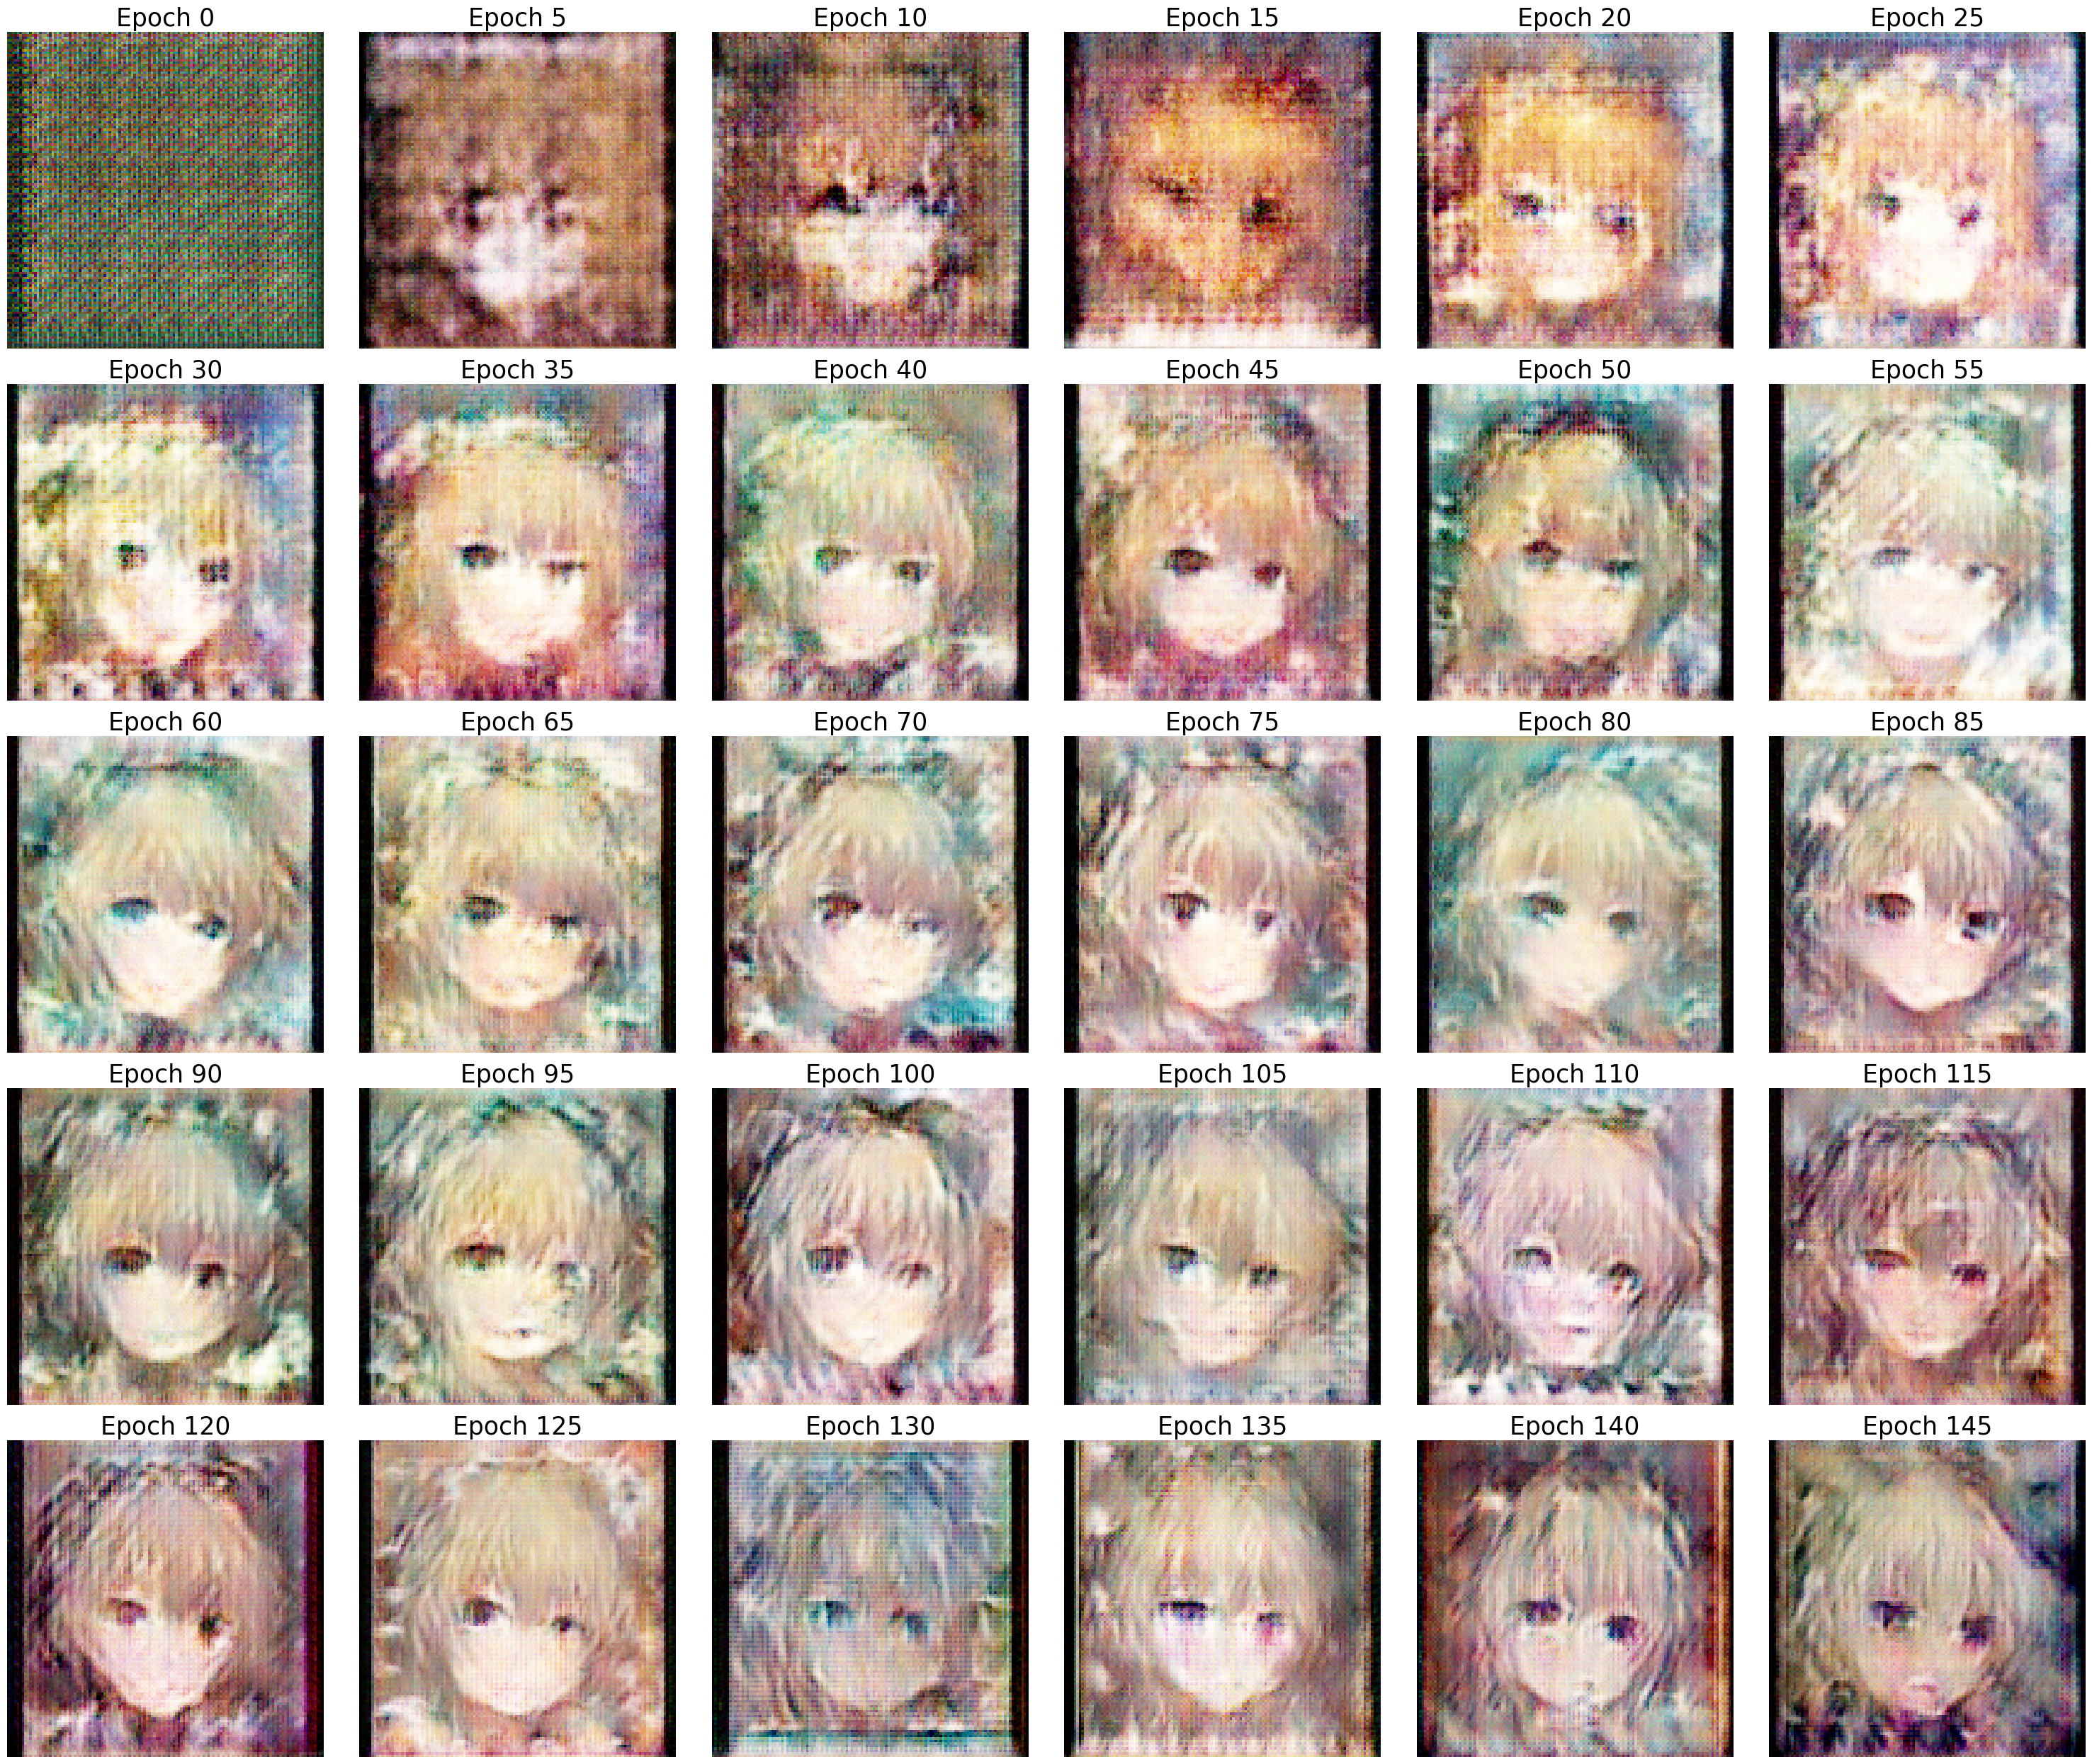

In [52]:
tensor_list = fake_images

titles = [f'Epoch {i * 5}' for i in range(len(tensor_list))]

num_images = len(tensor_list)
num_rows = int(num_images ** 0.5)
num_cols = (num_images // num_rows) + (0 if num_images % num_rows == 0 else 1)

fig, axarr = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows))
axarr = axarr.ravel() 

for ax, tensor, title in zip(axarr, tensor_list, titles):
    image_to_show = tensor.permute(1, 2, 0).numpy()
    ax.imshow(image_to_show)
    ax.set_title(title, fontsize = 25) 
    ax.axis('off')

for i in range(len(tensor_list), len(axarr)):
    axarr[i].axis('off')

plt.tight_layout()
plt.show()